In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set gnuplot style
plt.style.use('classic')

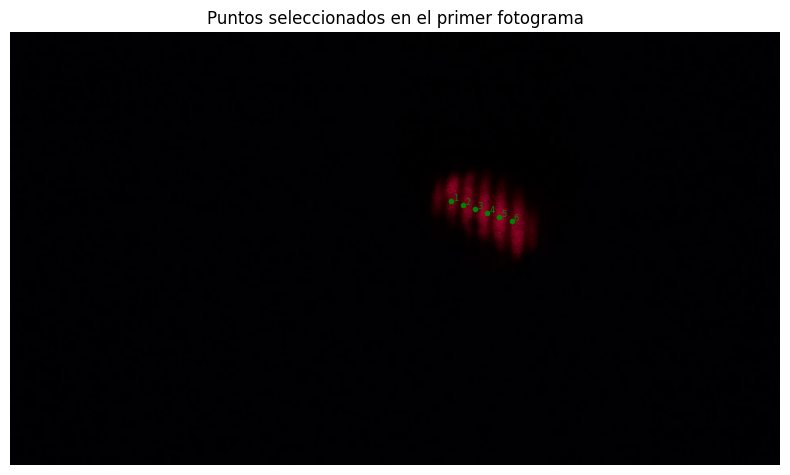

In [41]:
# Ruta al video
VIDEO_PATH = 'Mejor.mp4'  # <- cambia esto por el nombre real del archivo

# Coordenadas de los 6 puntos que deseas seguir (x, y)
# REEMPLAZA ESTAS COORDENADAS CON LAS QUE TÚ ELIJAS. Primera línea diagonal. Segunda línea completamente horizontal
puntos = [
    (1100, 420),
    #(1100, 430),
    
    (1130, 430),
    #(1130, 430),
    
    (1160, 440),
    #(1160, 430),
    
    (1190, 450),
    #(1190, 430),
    
    (1220, 460),
    #(1220, 430),
    
    (1250, 470),
    #(1250, 430)
]

# === CARGA DEL VIDEO Y PRIMER FRAME ===
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

if not ret:
    print("No se pudo leer el video.")
    exit()
    
# Convertir BGR (OpenCV) a RGB (matplotlib)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Dibujar los puntos sobre la imagen
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(frame_rgb)
for i, (x, y) in enumerate(puntos):
    ax.plot(x, y, 'g.')  # 'go' = green circle
    ax.text(x + 5, y, f'{i+1}', color='green', fontsize=6)

ax.set_title("Puntos seleccionados en el primer fotograma")
plt.axis('off')
plt.tight_layout()
plt.show()

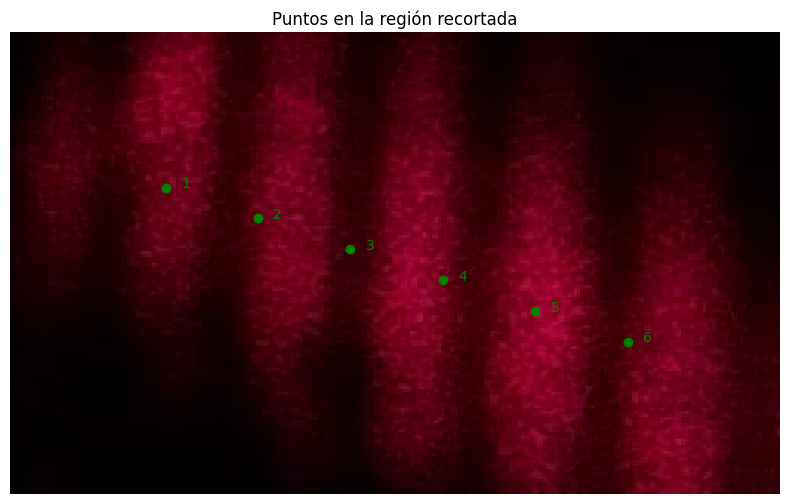

In [42]:
# === RECORTE AUTOMÁTICO ALREDEDOR DE LOS PUNTOS ===

# Convertir a numpy array para facilitar operaciones
puntos_np = np.array(puntos)

# Obtener límites de recorte
x_min = puntos_np[:, 0].min() - 50
x_max = puntos_np[:, 0].max() + 50
y_min = puntos_np[:, 1].min() - 50
y_max = puntos_np[:, 1].max() + 50

# Asegurar que no se salgan de la imagen
h, w, _ = frame_rgb.shape
x_min = max(0, x_min)
x_max = min(w, x_max)
y_min = max(0, y_min)
y_max = min(h, y_max)

# Recortar imagen
recorte = frame_rgb[int(y_min):int(y_max), int(x_min):int(x_max)]

# Ajustar puntos al nuevo marco (coordenadas relativas)
puntos_recorte = [(x - x_min, y - y_min) for (x, y) in puntos]

# === MOSTRAR LA IMAGEN RECORTADA CON LOS PUNTOS ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(recorte)
for i, (x, y) in enumerate(puntos_recorte):
    ax.plot(x, y, 'go')
    ax.text(x + 5, y, f'{i+1}', color='green', fontsize=10)

ax.set_title("Puntos en la región recortada")
plt.axis('off')
plt.tight_layout()
plt.show()

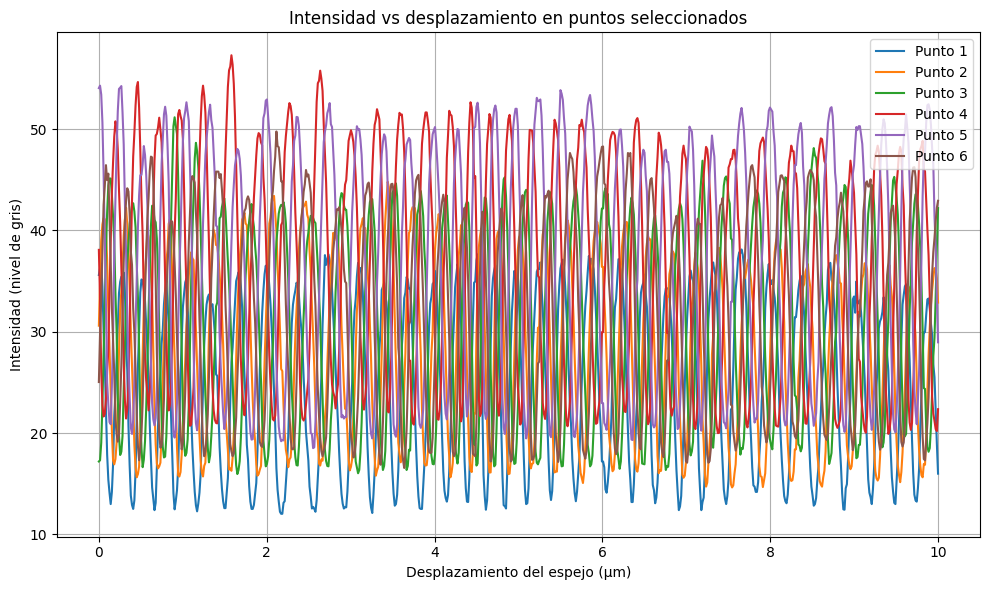

In [43]:
# Vamos por las intensidades
FPS = 60                  # cuadros por segundo
DESPLAZAMIENTO_TOTAL = 10e-6  # en metros (10 micras)
VENTANA = 5  # tamaño de la ventana (5x5)

# === LECTURA DEL VIDEO ===
cap = cv2.VideoCapture(VIDEO_PATH)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Inicializar arreglo de intensidades: shape (n_puntos, n_frames)
n_puntos = len(puntos)
intensidades = np.zeros((n_puntos, num_frames))

frame_idx = 0
mitad = VENTANA // 2

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir a escala de grises
    gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    h, w = gris.shape

    for i, (x, y) in enumerate(puntos):
        # Definir límites de la ventana (y, x)
        x1 = max(0, x - mitad)
        x2 = min(w, x + mitad + 1)
        y1 = max(0, y - mitad)
        y2 = min(h, y + mitad + 1)

        subzona = gris[y1:y2, x1:x2]
        promedio = np.mean(subzona)
        intensidades[i, frame_idx] = promedio

    frame_idx += 1

cap.release()

# === CONSTRUIR VECTOR DE DESPLAZAMIENTOS ===
# desplazamiento total en 10 micras, distribuido linealmente en los cuadros
desplazamientos = np.linspace(0, DESPLAZAMIENTO_TOTAL, num_frames)

# === GRAFICAR INTENSIDAD VS DESPLAZAMIENTO ===
plt.figure(figsize=(10, 6))

for i in range(n_puntos):
    plt.plot(desplazamientos * 1e6, intensidades[i], label=f'Punto {i+1}')  # en micras

plt.xlabel("Desplazamiento del espejo (μm)")
plt.ylabel("Intensidad (nivel de gris)")
plt.title("Intensidad vs desplazamiento en puntos seleccionados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

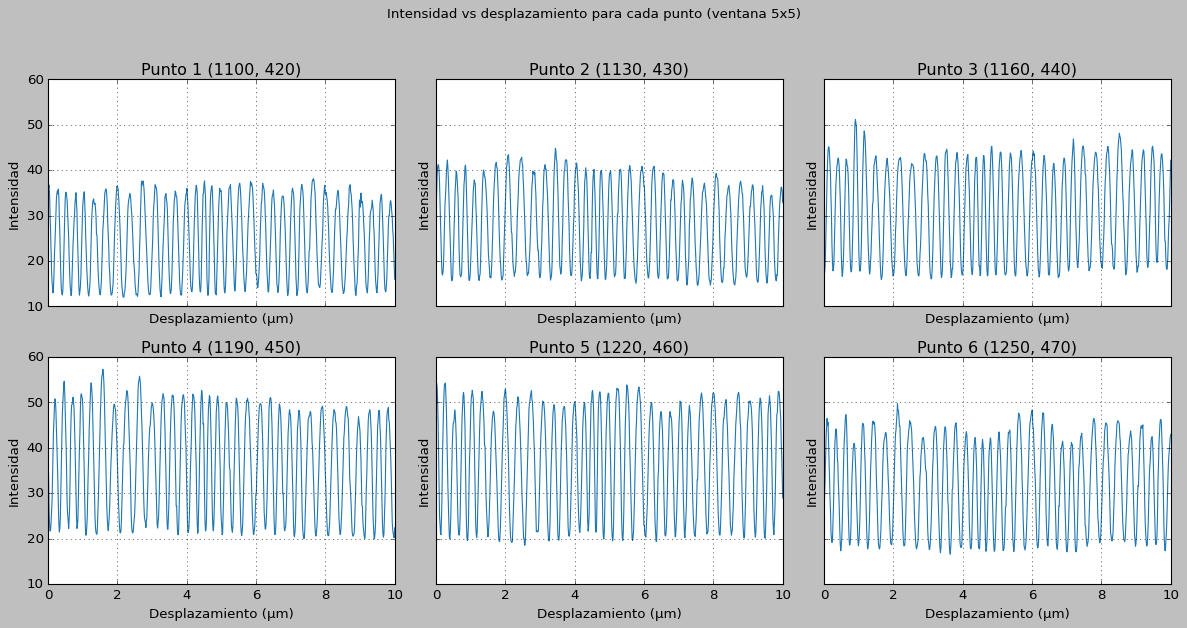

In [45]:
# === GRAFICAR EN 2x3 ===
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(n_puntos):
    axs[i].plot(desplazamientos * 1e6, intensidades[i], color='tab:blue')
    axs[i].set_title(f'Punto {i+1} ({puntos[i][0]}, {puntos[i][1]})')
    axs[i].set_xlabel("Desplazamiento (μm)")
    axs[i].set_ylabel("Intensidad")
    axs[i].grid(True)

plt.suptitle("Intensidad vs desplazamiento para cada punto (ventana {}x{})".format(VENTANA, VENTANA))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Resultados ---
Punto 1: 33 picos -> λ ≈ 606.1 nm
Punto 2: 33 picos -> λ ≈ 606.1 nm
Punto 3: 33 picos -> λ ≈ 606.1 nm
Punto 4: 33 picos -> λ ≈ 606.1 nm
Punto 5: 33 picos -> λ ≈ 606.1 nm
Punto 6: 34 picos -> λ ≈ 588.2 nm


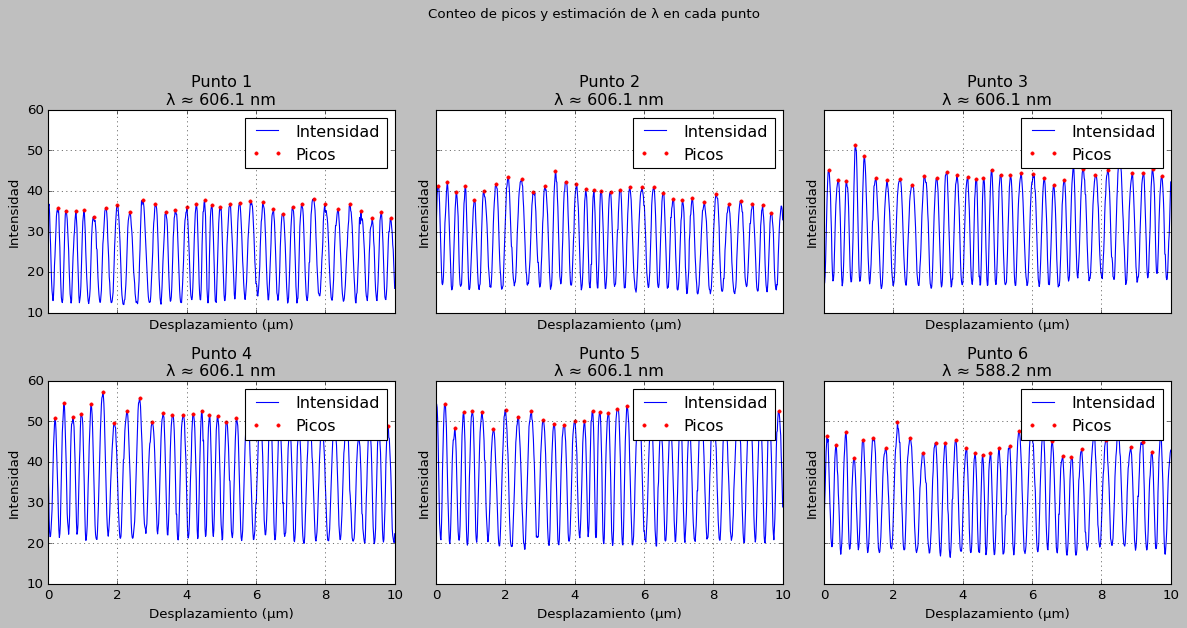

In [49]:
# === CONTEO DE PICOS Y CÁLCULO DE LONGITUD DE ONDA ===
longitudes_onda = []

print("\n--- Resultados ---")
for i in range(n_puntos):
    señal = intensidades[i]

    # Detectar picos (ajustar 'distance' si se detectan falsos)
    picos, _ = find_peaks(señal, prominence=5)  # puedes ajustar prominence si es necesario
    num_picos = len(picos)

    if num_picos > 0:
        lambda_estimada = (2 * DESPLAZAMIENTO_TOTAL) / num_picos  # en metros
    else:
        lambda_estimada = np.nan

    longitudes_onda.append(lambda_estimada)

    print(f"Punto {i+1}: {num_picos} picos -> λ ≈ {lambda_estimada*1e9:.1f} nm")

# === GRAFICAR LOS PICOS SOBRE LAS CURVAS ===
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(n_puntos):
    axs[i].plot(desplazamientos * 1e6, intensidades[i], label='Intensidad')
    
    # Picos
    picos, _ = find_peaks(intensidades[i], prominence=5)
    axs[i].plot(desplazamientos[picos] * 1e6, intensidades[i][picos], 'r.', label='Picos')

    axs[i].set_title(f'Punto {i+1}\nλ ≈ {longitudes_onda[i]*1e9:.1f} nm')
    axs[i].set_xlabel("Desplazamiento (μm)")
    axs[i].set_ylabel("Intensidad")
    axs[i].grid(True)
    axs[i].legend()

plt.suptitle("Conteo de picos y estimación de λ en cada punto")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

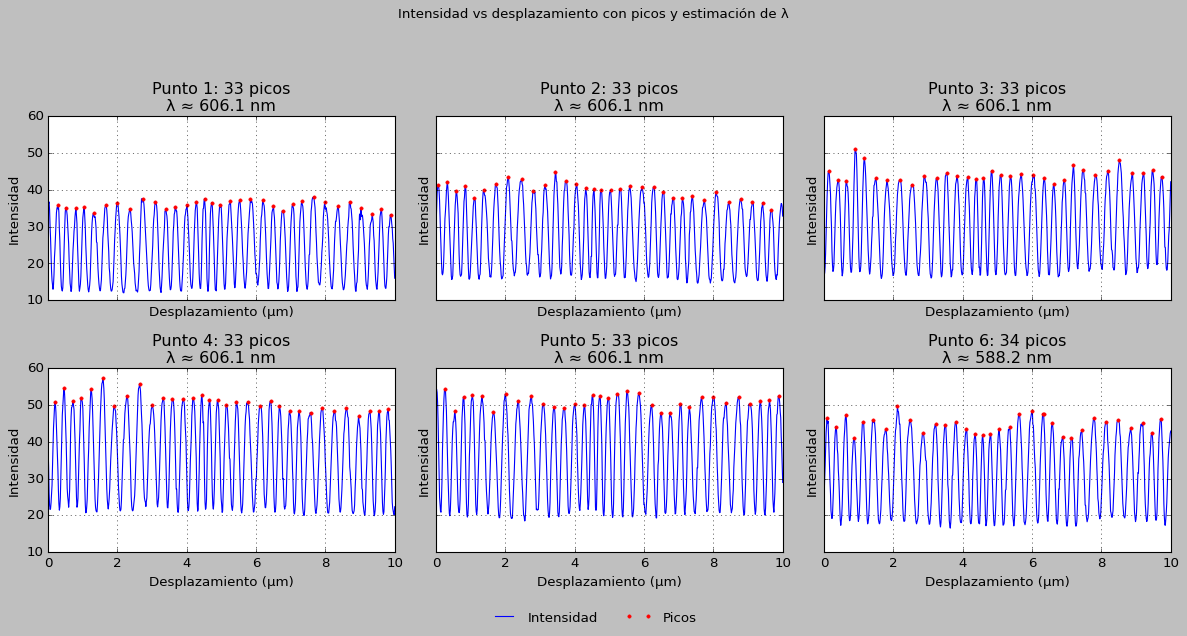


--- Resultados ---
Lambdas por punto (nm): [606.06060606 606.06060606 606.06060606 606.06060606 606.06060606
 588.23529412]
Promedio: 603.09 nm
Desviación estándar: 6.64 nm


In [52]:
# === CONTEO DE PICOS Y CÁLCULO DE λ ===
picos_por_curva = []
lambdas = []

for i in range(n_puntos):
    signal = intensidades[i]
    peaks, _ = find_peaks(signal, prominence=5)
    N = len(peaks)
    picos_por_curva.append(N)

    if N > 0:
        lambda_i = (2 * DESPLAZAMIENTO_TOTAL) / N
    else:
        lambda_i = np.nan

    lambdas.append(lambda_i)

# Convertir a arrays de numpy
picos_por_curva = np.array(picos_por_curva)
lambdas = np.array(lambdas)  # en metros

# === GRAFICAR ===
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(n_puntos):
    y = intensidades[i]
    peaks, _ = find_peaks(y, prominence=5)

    axs[i].plot(desplazamientos * 1e6, y, label='Intensidad')
    axs[i].plot(desplazamientos[peaks] * 1e6, y[peaks], 'r.', label='Picos')

    axs[i].set_title(f'Punto {i+1}: {picos_por_curva[i]} picos\nλ ≈ {lambdas[i]*1e9:.1f} nm')
    axs[i].set_xlabel("Desplazamiento (μm)")
    axs[i].set_ylabel("Intensidad")
    axs[i].grid(True)
    #axs[i].legend()

# Crear una leyenda global (con etiquetas únicas)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize='medium', frameon=False)

plt.suptitle("Intensidad vs desplazamiento con picos y estimación de λ")
plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # deja espacio para la leyenda global abajo
plt.show()

# === RESUMEN DE λ ===
media_lambda = np.nanmean(lambdas)
desv_lambda = np.nanstd(lambdas)

print("\n--- Resultados ---")
print(f"Lambdas por punto (nm): {lambdas * 1e9}")
print(f"Promedio: {media_lambda*1e9:.2f} nm")
print(f"Desviación estándar: {desv_lambda*1e9:.2f} nm")